## Predictive Maintenance for Manufacturing Machines

### Problem Statement
### Factories want to reduce downtime. build models that:
### Predict whether a machine is likely to fail soon.
### Classify the type of failure (e.g., tool wear failure (TWF), heat dissipation failure (HDF), etc.).

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    average_precision_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# Binary models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Multi-class models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


df = pd.read_csv("ai4i2020.csv")

print("Dataset shape:", df.shape)
print(df.head())
print(df.columns)


# Prepare features and targets

num_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]
cat_cols = ['Type'] if 'Type' in df.columns else []

# Binary target
y_bin = df['Machine failure'].astype(int)

#  Multi-class target
fail_cols = ['TWF','HDF','PWF','OSF','RNF']
df_mc = df[df[fail_cols].sum(axis=1) > 0].copy()
df_mc['failure_type'] = df_mc[fail_cols].idxmax(axis=1)
y_mc = df_mc['failure_type']

# Feature sets
X_bin = df[num_cols + cat_cols]
X_mc  = df_mc[num_cols + cat_cols]


#  Preprocessing (scaling + encoding)

numeric = Pipeline([("scaler", StandardScaler())])
categorical = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

if cat_cols:
    preproc = ColumnTransformer([
        ("num", numeric, num_cols),
        ("cat", categorical, cat_cols)
    ])
else:
    preproc = ColumnTransformer([("num", numeric, num_cols)])


#  Train/Test split

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bin, y_bin, test_size=0.2, stratify=y_bin, random_state=42
)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    X_mc, y_mc, test_size=0.2, stratify=y_mc, random_state=42
)

# For XGBoost: numeric labels
le = LabelEncoder()
ym_train_enc = le.fit_transform(ym_train)
ym_test_enc  = le.transform(ym_test)


#  Model 1 - Binary classification

print("\n=== Model 1: Failure Prediction (Binary) ===")

bin_models = {
    "LogisticRegression": LogisticRegression(max_iter=200, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier()
}

best_ap, best_name, best_pipe = -1, None, None

for name, clf in bin_models.items():
    pipe = Pipeline([("pre", preproc), ("clf", clf)])
    pipe.fit(Xb_train, yb_train)
    y_prob = pipe.predict_proba(Xb_test)[:,1]
    ap = average_precision_score(yb_test, y_prob)
    print(f"{name:>18s} | Average Precision (PR-AUC): {ap:.4f}")
    if ap > best_ap:
        best_ap, best_name, best_pipe = ap, name, pipe

# Evaluate best
y_pred = best_pipe.predict(Xb_test)
prec = precision_score(yb_test, y_pred, zero_division=0)
rec  = recall_score(yb_test, y_pred, zero_division=0)
print(f"\nBest Model: {best_name} (AP={best_ap:.4f})")
print(f"Precision={prec:.3f}, Recall={rec:.3f}")


#  Model 2 - Multi-class classification

print("\n=== Model 2: Failure Type Classification (Multi-class) ===")

mc_models = {
    "DecisionTree": DecisionTreeClassifier(max_depth=8, class_weight="balanced"),
    "SVM_RBF": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, objective="multi:softprob",
        eval_metric="mlogloss", tree_method="hist"
    )
}

best_f1, best_mc_name, best_mc_pipe = -1, None, None

for name, clf in mc_models.items():
    pipe = Pipeline([("pre", preproc), ("clf", clf)])
    
    if name == "XGBoost":
        pipe.fit(Xm_train, ym_train_enc)  # numeric labels
        ym_pred_enc = pipe.predict(Xm_test)
        ym_pred = le.inverse_transform(ym_pred_enc)
    else:
        pipe.fit(Xm_train, ym_train)
        ym_pred = pipe.predict(Xm_test)

    report = classification_report(ym_test, ym_pred, output_dict=True)
    macro_f1 = report["macro avg"]["f1-score"]
    print(f"{name:>18s} | Macro-F1: {macro_f1:.3f}")

    if macro_f1 > best_f1:
        best_f1, best_mc_name, best_mc_pipe = macro_f1, name, pipe

# Final evaluation
if best_mc_name == "XGBoost":
    ym_pred_enc = best_mc_pipe.predict(Xm_test)
    ym_pred = le.inverse_transform(ym_pred_enc)
else:
    ym_pred = best_mc_pipe.predict(Xm_test)

print(f"\nBest Model: {best_mc_name} (Macro-F1={best_f1:.3f})")
print("\nClassification Report:")
print(classification_report(ym_test, ym_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(ym_test, ym_pred))


Dataset shape: (10000, 14)
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    

### Gradient Boosting is best for predicting whether a failure will happen soon.
### XGBoost is best for predicting which type of failure, with strong overall accuracy but challenges on rare failure types.

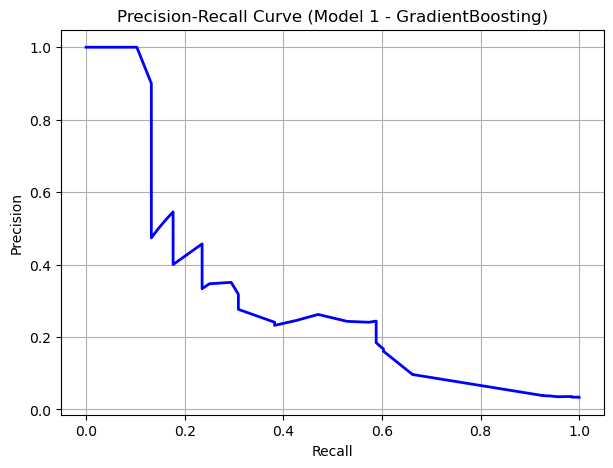

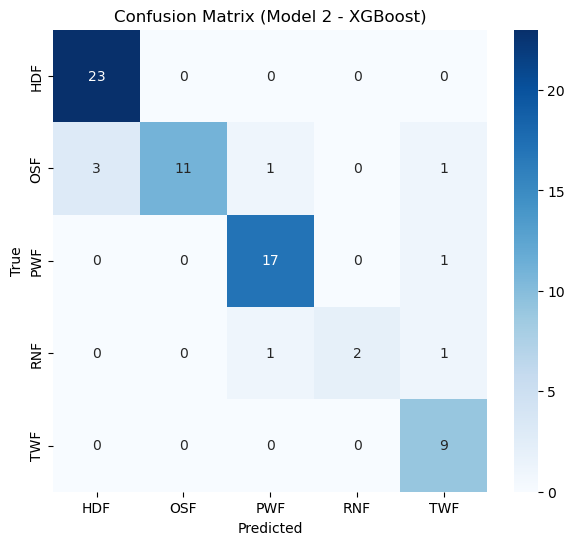

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve


if hasattr(best_pipe.named_steps['clf'], "predict_proba"):
    y_scores = best_pipe.predict_proba(Xb_test)[:,1]
else:
    y_scores = best_pipe.decision_function(Xb_test)

precisions, recalls, thresholds = precision_recall_curve(yb_test, y_scores)

plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, linewidth=2, color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (Model 1 - {best_name})")
plt.grid(True)
plt.show()


labels = sorted(ym_test.unique())

cm = confusion_matrix(ym_test, ym_pred, labels=labels)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix (Model 2 - {best_mc_name})")
plt.show()


### Binary prediction (Model 1): Reliable, but you should tune threshold depending on whether the factory values catching all failures (recall) or reducing false alarms (precision).

### Failure type classification (Model 2): XGBoost provides high accuracy and clear separation of common failures, but needs more data or resampling to improve rare types.